In [70]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations, compress
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import random
from sklearn.neighbors import KernelDensity
import math

import sys
sys.path.append('../')
from phase.input_output import PhaseData

In [62]:
data_dir = '../../DATA/ssc.hg38'
phase_name = None

crossover_cutoff = 500
colors = ['#ef6c00ff', '#4db6acff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]

In [67]:
phase_data = PhaseData(data_dir, phase_name)
sibpairs = phase_data.get_sibpairs()
crossovers = phase_data.get_crossovers()

print('sibpairs', len(sibpairs))
print('crossovers', len(crossovers))

sibpairs 1161
crossovers 168920


In [69]:
crossover_lengths = np.array([co['end_pos']-co['start_pos'] for co in crossovers])
mat_crossovers = np.array([x['maternal_crossovers'] for x in sibpairs])
pat_crossovers = np.array([x['paternal_crossovers'] for x in sibpairs])

is_outlier = np.array([x['is_crossover_outlier'] for x in sibpairs])

KeyError: 'maternal_crossovers'

# Crossover stats

In [68]:
# pull Kong data

assembly='38'
crossover_len_mat_kong, crossover_len_pat_kong = [], []
with open('../data/DECODE/DECODE_Recombination_Events_Maternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0][3:]
        #if chrom != 'X':
        start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
        crossover_len_mat_kong.append(end_pos-start_pos)
with open('../data/DECODE/DECODE_Recombination_Events_Paternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0][3:]
        #if chrom != 'X':
        start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
        crossover_len_pat_kong.append(end_pos-start_pos)

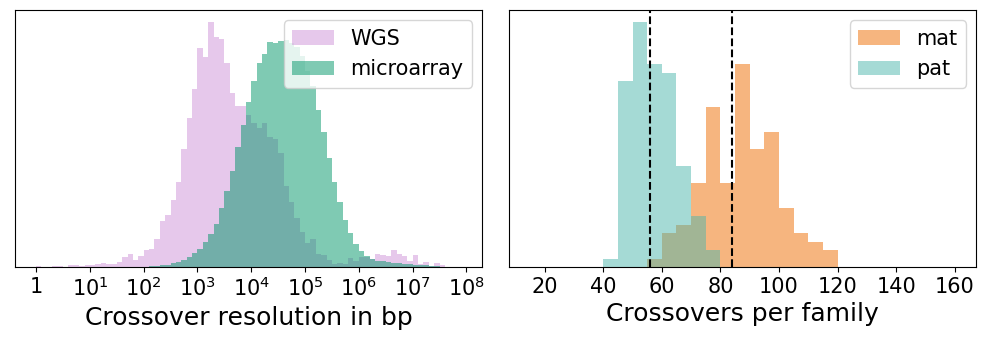

In [55]:
plt.figure(figsize=(10, 3.5))

plt.subplot(1, 2, 1)
plt.hist(np.log10(crossover_lengths), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label='WGS', color=colors[4])
plt.hist(np.log10(np.hstack((crossover_len_mat_kong, crossover_len_pat_kong))), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label='microarray', color=colors[5])
plt.xlabel('Crossover resolution in bp', fontsize=18)
plt.xticks(np.arange(0, 9), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9)], fontsize=15)
plt.yticks([])
plt.legend(fontsize=15, loc='upper right')

#plt.subplot(1, 3, 2)
#plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
#plt.scatter(mat_crossovers[~is_outlier], pat_crossovers[~is_outlier], marker='.', color=colors[2])
#plt.xlabel('Maternal crossovers per family', fontsize=18)
#plt.ylabel('Paternal crossovers per family', fontsize=18)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.axvline(42*2, color='black', linestyle='--')
#plt.axhline(28*2, color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(mat_crossovers[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), 
         label='mat', color=colors[0])
plt.hist(pat_crossovers[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), 
         label='pat', color=colors[1])
plt.axvline(42*2, color='black', linestyle='--')
plt.axvline(28*2, color='black', linestyle='--')
plt.xlabel('Crossovers per family', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks([])
plt.legend(fontsize=15)
#plt.ylabel('Density', fontsize=18)

plt.tight_layout()
plt.show()

In [66]:
# remove twins
is_twin = np.array([x['is_identical'] if x['is_identical'] is not None else False for x in sibpairs])
is_outlier = is_twin | (mat_crossovers > crossover_cutoff) | (pat_crossovers > crossover_cutoff)
print(np.sum(is_outlier))



1


In [51]:
x_min, x_max = np.round(np.min(mat_crossovers[~is_outlier]), -1)-10, np.round(np.max(mat_crossovers[~is_outlier]), -1)+10
y_min, y_max = np.round(np.min(pat_crossovers[~is_outlier]), -1)-10, np.round(np.max(pat_crossovers[~is_outlier]), -1)+10

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mat_crossovers[~is_outlier, np.newaxis],
                                                                    pat_crossovers[~is_outlier, np.newaxis]))) 
xintervals = np.arange(x_min, x_max)
yintervals = np.arange(y_min, y_max)
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))
predict_outlier = kde.score_samples(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])))



1.522115019289785 13.718454534665314
5


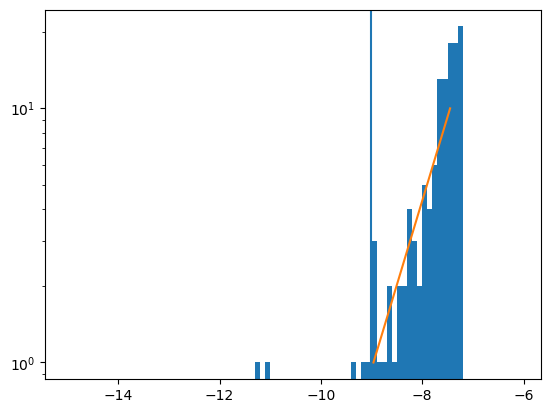

In [52]:
bins = np.arange(-15, -6, 0.1)
ns, _, _ = plt.hist(predict_outlier, bins=bins, log=True)
start_index, end_index = 60, 75
m, b = np.polyfit(bins[start_index:end_index], np.log(ns[start_index:end_index]), 1)

outlier_cutoff = -b/m

plt.plot([outlier_cutoff+0.05, bins[end_index]+0.05], [np.exp(m*outlier_cutoff+b), np.exp(m*bins[end_index]+b)])
print(m, b)
plt.axvline(outlier_cutoff)

is_outlier = is_outlier | (predict_outlier<outlier_cutoff)

print(np.sum(is_outlier))

plt.show()

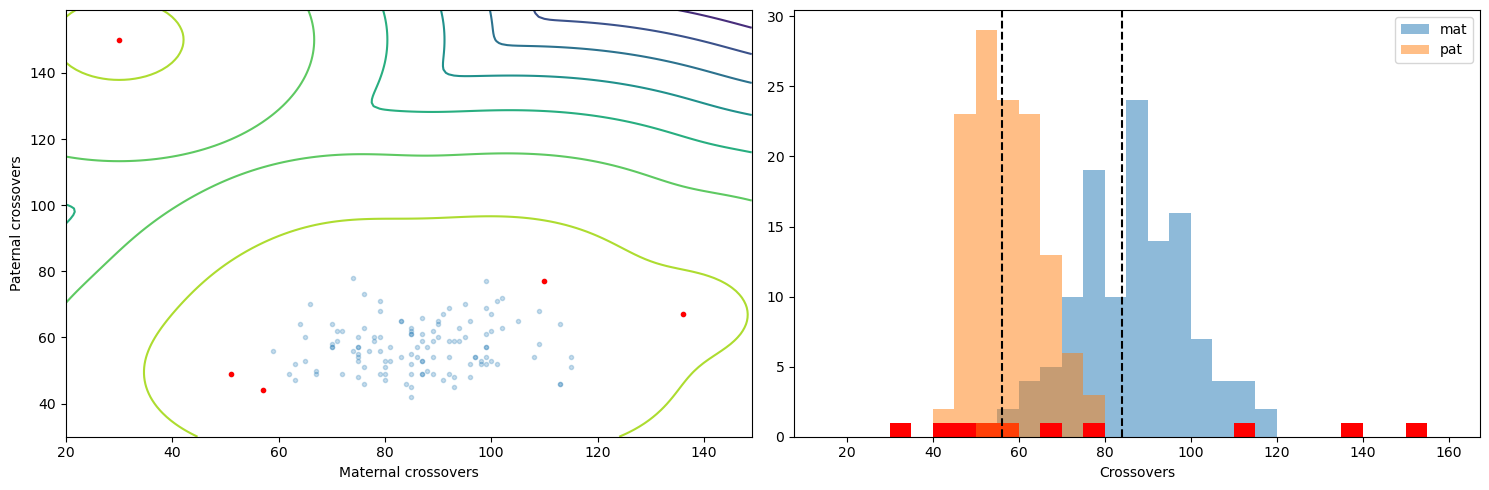

In [60]:
# gaussian
#mean = np.mean(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])), axis=0)
#cov = np.cov(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])), rowvar=0)

#x, y = np.mgrid[40:150, 40:100]
#pos = np.dstack((x, y))
#rv = stats.multivariate_normal(mean, cov)
#plt.contour(x, y, rv.pdf(pos))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
plt.scatter(mat_crossovers, pat_crossovers, marker='.', alpha=0.25)
plt.scatter(mat_crossovers[is_outlier], pat_crossovers[is_outlier], marker='.', color='red')
plt.xlabel('Maternal crossovers')
plt.ylabel('Paternal crossovers')

plt.subplot(1, 2, 2)
plt.hist(mat_crossovers, alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), label='mat')
plt.hist(mat_crossovers[is_outlier], bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), color='red')
plt.hist(pat_crossovers, alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), label='pat')
plt.hist(pat_crossovers[is_outlier], bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), color='red')
plt.axvline(42*2, color='black', linestyle='--')
plt.axvline(28*2, color='black', linestyle='--')
plt.xlabel('Crossovers')
plt.legend()

plt.tight_layout()
plt.show()

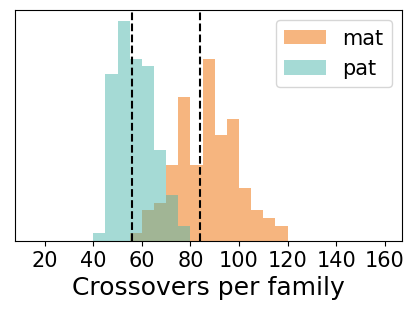

In [56]:
plt.figure(figsize=(5, 3))

#plt.subplot(1, 2, 1)
plt.hist(mat_crossovers[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), 
         label='mat', color=colors[0])
plt.hist(pat_crossovers[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), 
         label='pat', color=colors[1])
plt.axvline(42*2, color='black', linestyle='--')
plt.axvline(28*2, color='black', linestyle='--')
plt.xlabel('Crossovers per family', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks([])
plt.legend(fontsize=15)
#plt.ylabel('Density', fontsize=18)
plt.show()

In [57]:
print(np.mean(mat_crossovers[~is_outlier]),
     np.mean(pat_crossovers[~is_outlier]))

86.21008403361344 57.134453781512605


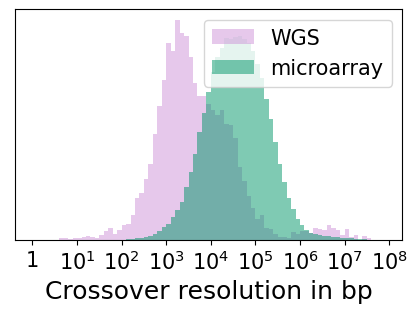

In [58]:
plt.figure(figsize=(5, 3))

#plt.subplot(1, 2, 1)
plt.hist(np.log10(crossover_lengths), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label='WGS', color=colors[4])
plt.hist(np.log10(np.hstack((crossover_len_mat_kong, crossover_len_pat_kong))), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label='microarray', color=colors[5])
plt.xlabel('Crossover resolution in bp', fontsize=18)
plt.xticks(np.arange(0, 9), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9)], fontsize=15)
plt.yticks([])
plt.legend(fontsize=15, loc='upper right')
plt.show()